# ポートフォリオ・バックテストのデモ

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta

In [1]:
# download prices from yahoo finance
from yahoo_fin import stock_info as si
assets = { 'equity':'IVV', 'bond':'AGG', 'cash':'SHY', 'em':'EEM', 'dm':'EFA' }
prices = {k:si.get_data(v) for k,v in assets.items()}

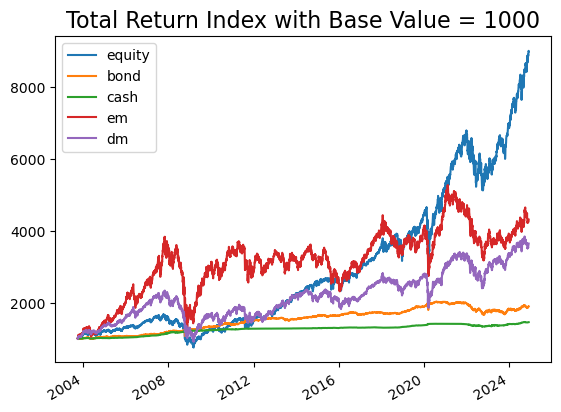

In [5]:
# transfer and plot total retun prices
totidx = pd.DataFrame.from_dict({
    k:v.adjclose for k,v in prices.items()
})\
.dropna()\
.apply(lambda x: x/x.iloc[0]*1000)
totidx.plot()
plt.title('Total Return Index with Base Value = 1000', {'fontsize':16})
plt.show()

In [7]:
# show some basic performance stats
mret = totidx.asfreq('ME',method='ffill').pct_change().dropna()
pd.DataFrame.from_dict({
 'annualized monthly return':mret.mean()*12*100,
 'annualized monthly volatility':mret.std()*np.sqrt(12)*100,
 'annualized monthly sharpe':mret.mean() / mret.std() * np.sqrt(12),
}).T.round(2)

,equity,bond,cash,em,dm
annualized monthly return,11.53,3.09,1.78,9.10,7.56
annualized monthly volatility,14.68,4.50,1.51,21.06,16.88
annualized monthly sharpe,0.78,0.69,1.18,0.43,0.45


C:\Users\nicjp\AppData\Local\Temp\ipykernel_22664\2223131089.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weights['aggressive']= pd.DataFrame( data={'equity':.8,'bond':.2}, index=reb_dates, columns=totidx.columns ).fillna(0)
C:\Users\nicjp\AppData\Local\Temp\ipykernel_22664\2223131089.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weights['moderate']= pd.DataFrame( data={'equity':.6,'bond':.4}, index=reb_dates, columns=totidx.columns ).fillna(0)
C:\Users\nicjp\AppData\Local\Temp\ipykernel_22664\2223131089.py:6: FutureWarning: Downcasting obje

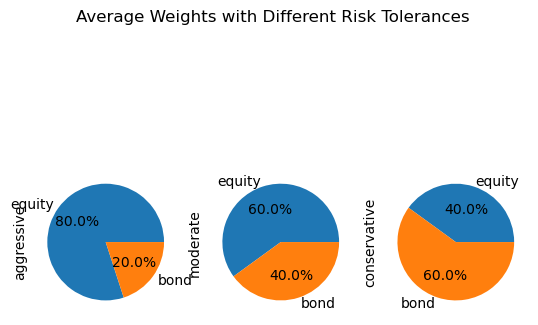

In [9]:
# create fixed-weighted portfolios based on risk-tolerance
reb_dates = totidx.asfreq('QE').index
weights = dict()
weights['aggressive']= pd.DataFrame( data={'equity':.8,'bond':.2}, index=reb_dates, columns=totidx.columns ).fillna(0)
weights['moderate']= pd.DataFrame( data={'equity':.6,'bond':.4}, index=reb_dates, columns=totidx.columns ).fillna(0)
weights['conservative']= pd.DataFrame( data={'equity':.4,'bond':.6}, index=reb_dates, columns=totidx.columns ).fillna(0)
# plot average weights
pd.concat({k:v.mean() for k,v in weights.items()},axis=1)\
 .loc[['equity','bond']]\
 .plot.pie(autopct='%1.1f%%',subplots=True,legend=False)
plt.suptitle('Average Weights with Different Risk Tolerances')
plt.show()

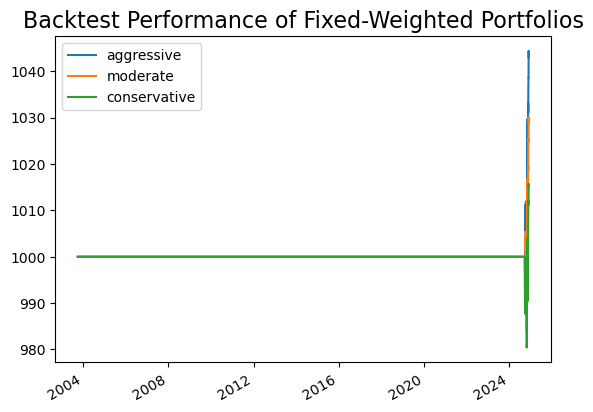

C:\Users\nicjp\AppData\Local\Temp\ipykernel_22664\1196850552.py:28: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  mret = test1.asfreq('m',method='ffill').pct_change().dropna()


,aggressive,moderate,conservative
annualized monthly return,0.17,0.11,0.05
annualized monthly volatility,1.12,0.94,0.78
annualized monthly sharpe,0.16,0.12,0.07


In [14]:
# simple backtest function
def backtest(w,prices, v0=1000,t=0,start_date=None):
 
 p = prices[w.columns]
 v = pd.DataFrame(data = v0*np.ones(len(p)),index=p.index)
 
 for i in w.index:
 # i = rebalance date ; t = trade offset, d = effective date
   d = i + timedelta(t) 
   w_i = np.array(w.loc[:i].tail(1)).flatten()
   v_i = np.array(v.loc[:d].tail(1)).flatten()
   p_i = p.loc[d:]
 
 v.update( (p_i/p_i.iloc[0]).dot(v_i * w_i) ) 
 
 if start_date is not None:
   v = v[start_date:]
   v = v/v.iloc[0]*v0
 
 return(v)

# run backtest
test1 = pd.DataFrame.from_dict({k:backtest(v,totidx)[0] for k,v in weights.items()})
test1.plot()
plt.title('Backtest Performance of Fixed-Weighted Portfolios',{'fontsize':16})
plt.show()
# performance review
mret = test1.asfreq('m',method='ffill').pct_change().dropna()
pd.DataFrame.from_dict({
 'annualized monthly return':mret.mean()*12*100,
 'annualized monthly volatility':mret.std()*np.sqrt(12)*100,
 'annualized monthly sharpe':mret.mean() / mret.std() * np.sqrt(12),
}).T.round(2)

In [16]:
# create momentum ranks
mtridx = totidx.asfreq('ME',method='ffill')[['equity','dm','em','bond']]
mranks=dict()
mranks['3m']= mtridx.pct_change(3).dropna()\
                    .rank(axis=1,ascending=False)
mranks['6m']= mtridx.pct_change(6).dropna()\
                    .rank(axis=1,ascending=False)
mranks['9m']= mtridx.pct_change(9).dropna()\
                    .rank(axis=1,ascending=False)
mranks['12m']= mtridx.pct_change(12).dropna()\
                    .rank(axis=1,ascending=False)

In [18]:
# convert ranks to weights (1=0.4, 2=0.3, 3=0.2 , 4=0.1)
s = {1:0.4,2:0.3,3:0.2,4:0.1}
def rankWeights(m,s):
 w = pd.DataFrame(data = 0,index=m.index,columns=m.columns)
 for k,v in s.items(): w[m==k]=v
 w['cash']=1-w.sum(axis=1).round(2)
 return w
# add weights to list
for k,v in mranks.items():
 weights[k]=rankWeights(v,s).asfreq('QE',method='ffill').dropna()

C:\Users\nicjp\AppData\Local\Temp\ipykernel_22664\1965796134.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  for k,v in s.items(): w[m==k]=v
C:\Users\nicjp\AppData\Local\Temp\ipykernel_22664\1965796134.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  for k,v in s.items(): w[m==k]=v
C:\Users\nicjp\AppData\Local\Temp\ipykernel_22664\1965796134.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  for k,v in s.items(): w[m==k]=v
C:\Users\nicjp\AppData\Local\Temp\

In [19]:
def eff_frontier(mu, sigma, clip=(0,1), dr=0.0025, symbols=list(mu.index)):
 
 pfRet = lambda x: x.dot(mu)
 pfVar = lambda x: x.dot(sigma).dot(x) 
 
 w = w0 = np.ones(len(mu))/len(mu)
 mus = np.arange(start=mu.min(), stop=mu.max()+dr, step=dr, dtype='float')
 results = pd.DataFrame(index=mus, columns=['return','risk','sharpe'] + symbols)
 
 for r in mus:
   w_constraints = (
   {'type': 'eq', 'fun':lambda x:sum(x)-1.},
   {'type': 'eq', 'fun':lambda x:pfRet(x)-r},
   ) 
   w_opt = minimize(pfVar, w, method='SLSQP', constraints=w_constraints, bounds = [clip]*len(w) )
   w = w_opt.x
   results.loc[r]=[ pfRet(w), np.sqrt(pfVar(w)), pfRet(w) / np.sqrt(pfVar(w)) ] + list(w)
 
   return results.reset_index(drop=True)

NameError: name 'mu' is not defined